# Multi-label Toxic Comment Classification

## 1 - Introducion

In this project, we tackle the multi-label toxic comment classification problem using a dataset from the Toxic Comment Classification Challenge on Kaggle.

The dataset consists of a large number of Wikipedia comments, labeled with six categories of toxicity:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Our goal is to build a machine learning model that can accurately identify and classify the presence of these toxic elements in the comments.

## 2 - Installing / Importing / Download

Before start, you need to unzip the data file and download and unzip the GloVe embedding weights.<br><br>
The toxic datasets can be downloaded under [this link](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data).<br>
Also, the GloVe files can be downloaded manually under [this link](https://nlp.stanford.edu/data/glove.6B.zip).<br><br>
The below cell script will make it happen automatically.

In [ ]:
!unzip data.zip
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip -p glove.6B.zip glove.6B.100d.txt > data/glove.6B.100d.txt

After having the datasets and the GloVe file inside '/data' folder, it's time to install needed Python libraries.

In [ ]:
%pip install -r requirements.txt

Import all necessary libraries for data manipulation, visualization, text processing, and model building.

In [1]:
# Importing necessary libraries
import os

# Importing Matplotlib and Seaborn libraries - data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing Pandas and Numpy libraries - data manipulation
import pandas as pd
import numpy as np

# Importing Swifter library - faster Pandas apply
import swifter

# Importing NLTK libraries - text processing
import re
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

# Importing Keras libraries - model building
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Downloading NLTK libraries - text processing
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("averaged_perceptron_tagger")
nltk.download('omw-1.4')

## 3 - Loading and Preparing the Data

Load the training and testing datasets, then merge the test datasets, and replace -1 with NaN values and drop rows with missing values.

In [2]:
# Loading datasets
df_train = pd.read_csv('data/train.csv', index_col='id')

# Merging test datasets
df_test_text = pd.read_csv('data/test.csv', index_col='id')
df_test_labels = pd.read_csv('data/test_labels.csv', index_col='id')
df_test = df_test_text.merge(df_test_labels, on='id')
df_test = df_test.replace(-1, np.nan).dropna()

## 4 - Text Processing

Define functions for text processing, including:
- get_wordnet_pos(): Get the WordNet POS tag for a given POS tag.
- lemmatize_tokens(): Lemmatize a list of tokens using their POS tags.
- text_processing(): Preprocess text by removing URLs, converting to lowercase, tokenizing, removing stopwords, punctuation, and numbers, and performing lemmatization.

In [3]:
def get_wordnet_pos(tag):
    """Get the WordNet POS tag for a given POS tag."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [4]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    """Lemmatize a list of tokens using their POS tags."""
    pos_tag_tokens = pos_tag(tokens)
    lemm_list = []

    for tag in pos_tag_tokens:
        lemm_token = lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1]))
        lemm_list.append(lemm_token)

    return lemm_list

In [5]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
stop_words_punct = set(stopwords.words('english')).union(set(string.punctuation))
def text_processing(text):
    """
    Preprocess a given text by removing URLs, lowercase, tokenization, stopword and punctuation removal,
    number removal, and lemmatization.
    """
    # Filtering URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "<urlplaceholder>")

    # Stripping and lowercasing the input text
    text = text.strip().lower()

    # Tokenization
    words = word_tokenize(text)

    # Stopword, punctuation, and number removal
    words = [token for token in words if (len(token) > 2) and (token not in stop_words_punct) and not token.isdigit()]

    # Lemmatization
    words = lemmatize_tokens(words)

    # Returning the processed sentence
    return ' '.join(words)

Apply the text processing function to the training and testing datasets.

Using the Py library 'swifter' to speed up the text processing Pandas function apply.

In [6]:
# Clear comments text
df_train['comment_text_cleaned'] = df_train['comment_text'].swifter.apply(text_processing)
df_test['comment_text_cleaned'] = df_test['comment_text'].swifter.apply(text_processing)

Pandas Apply:   0%|          | 0/159571 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/63978 [00:00<?, ?it/s]

## 5 - Data Analysis and Visualization

Printing random comments - Deleted outputs due to curse words.

In [ ]:
# Printing random comments before 
df_train.sample(1)['comment_text']

In [ ]:
# and after cleaning
df_train.sample(1)['comment_text_cleaned']

Calculate word count for each comment, then plotting word count distribution for both the training and testing datasets.<br>
The calculation is basically a labda funciton that splits the comment text into words and count them for each row.

In [9]:
# Applying comments cleaning function to whole datasets
df_train['word_count'] = df_train['comment_text_cleaned'].swifter.apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['comment_text_cleaned'].swifter.apply(lambda x: len(str(x).split()))

Pandas Apply:   0%|          | 0/159571 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/63978 [00:00<?, ?it/s]

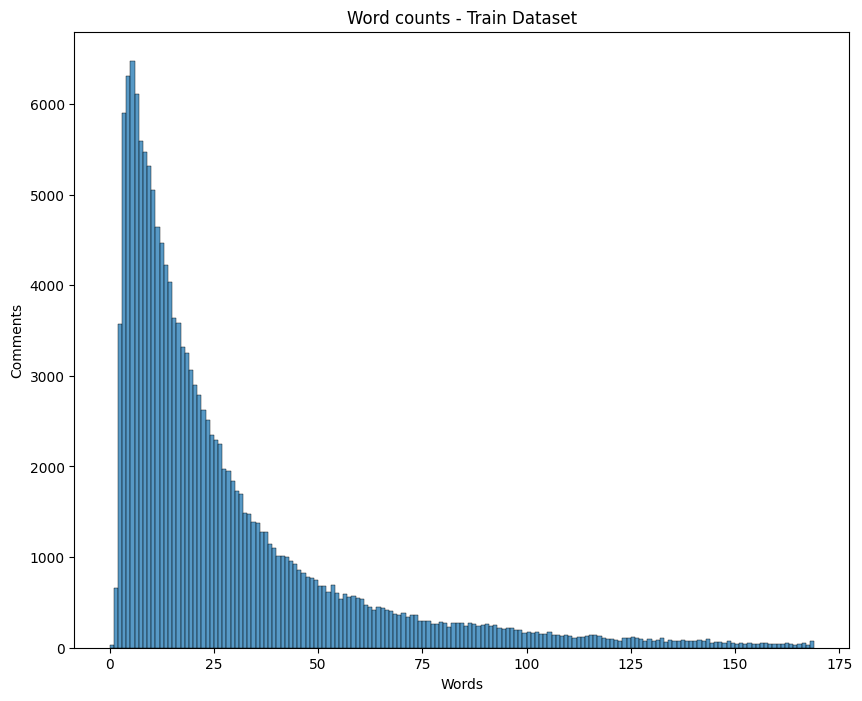

In [10]:
# Plotting word counts for train dataset
df_plot_train = df_train[df_train['word_count'] < 170]

plt.figure(figsize=(10,8))
sns.histplot(data=df_plot_train, x='word_count')
plt.title('Word counts - Train Dataset')
plt.xlabel('Words')
plt.ylabel('Comments')
plt.show()

In [11]:
train_comments = (sum(df_train['word_count'] < 170)/df_train.shape[0])*100
print('{:.2f}% of the words have <170.'.format(train_comments))

97.37% of the words have <170.


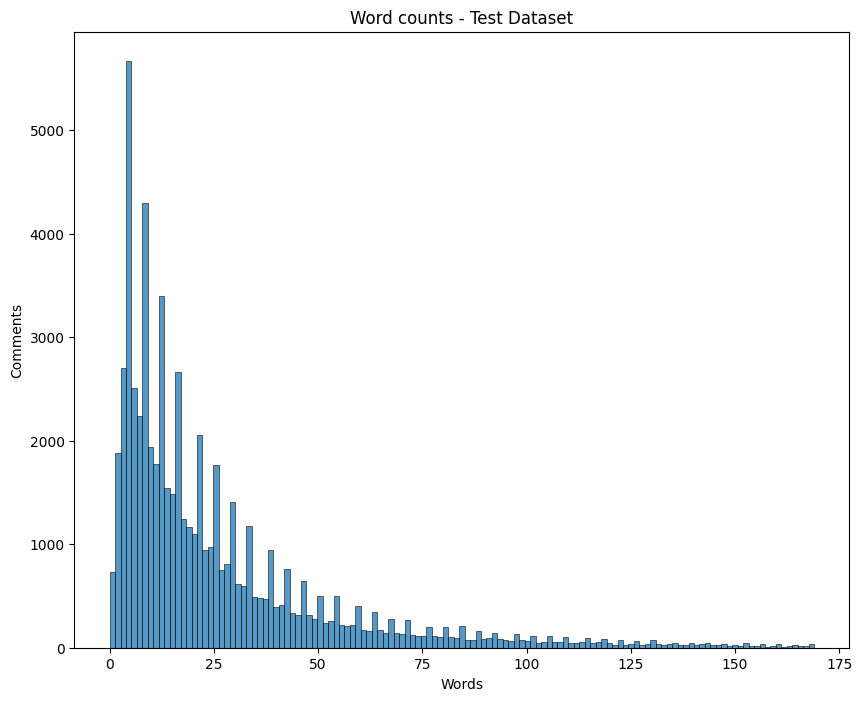

In [12]:
# Plotting word counts for test dataset
df_plot_test = df_test[df_test['word_count'] < 170]

plt.figure(figsize=(10,8))
sns.histplot(data=df_plot_test, x='word_count')
plt.title('Word counts - Test Dataset')
plt.xlabel('Words')
plt.ylabel('Comments')
plt.show()

In [13]:
test_comments = (sum(df_test['word_count'] < 170)/df_test.shape[0])*100
print('{:.2f}% of the words have <170.'.format(test_comments))

97.37% of the words have <170.


Plot label distribution for the training dataset only.<br>
Here we can clearly see our imbalanced dataset.

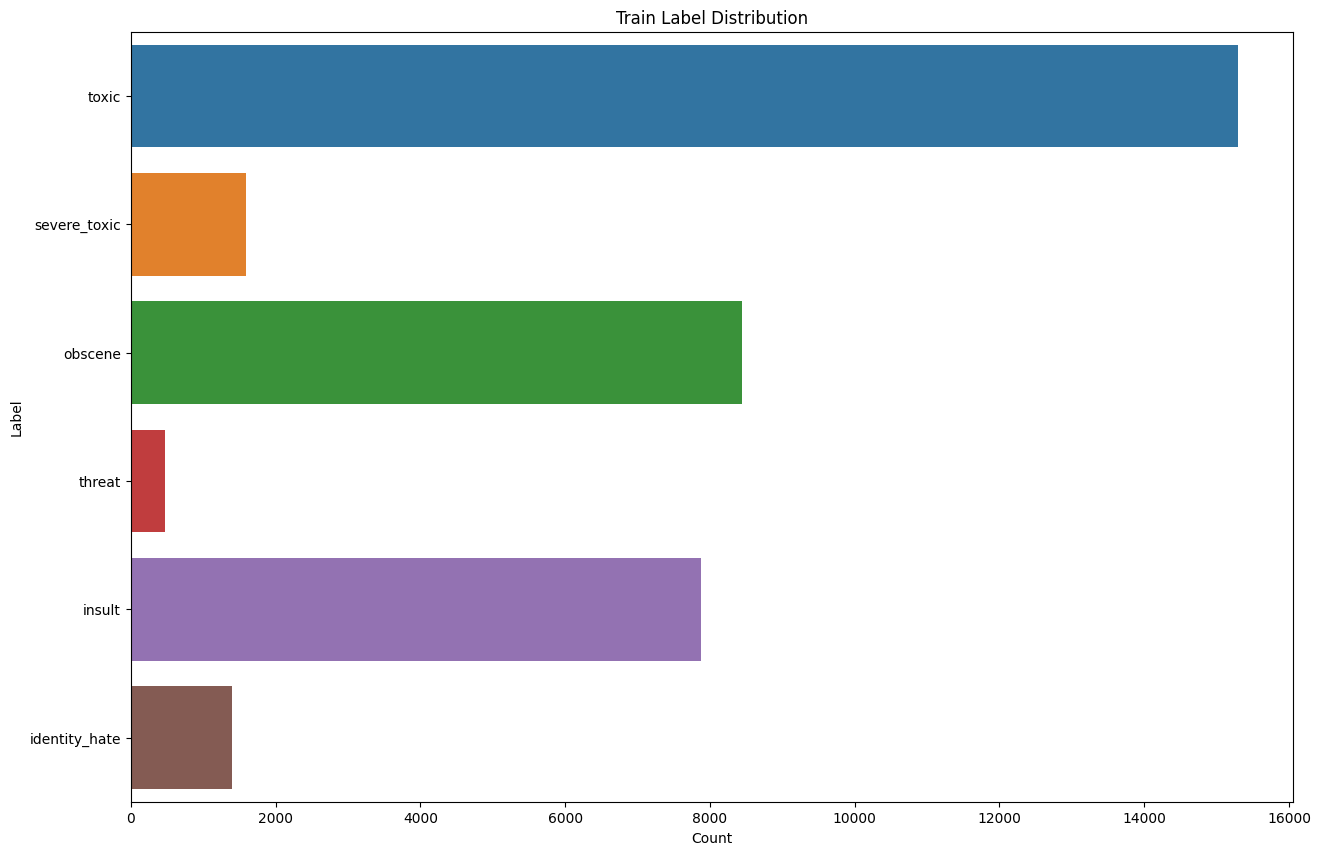

In [14]:
# Plotting label distribution for train dataset
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df_plot_labels = df_train[df_train[label_columns] == 1][label_columns].count()

plt.figure(figsize=(15,10))
sns.barplot(x=df_plot_labels.values, y=df_plot_labels.index)
plt.title('Train Label Distribution')
plt.xlabel('Count')
plt.ylabel('Label')
plt.show()

## 6 - Tokenization and Padding

Create a tokenizer and fit it on the training dataset.<br>
It will generate an word indexer as a vocaulary, so we can have the index word size.

In [15]:
# Creating Tokenizer
filters = '!"#$%&()*+,-./:;<=>@[\]^_`{|}~ '
tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>', filters=filters)
tokenizer.fit_on_texts(df_train['comment_text_cleaned'])

In [16]:
vocab_size = len(tokenizer.index_word) + 1
print('Total words in vocabulary: ', vocab_size)

Total words in vocabulary:  174468


Tokenizing and padding the text data for both the training and testing datasets.<br>
The padding will add zeros to the Tokenized vectors.

In [17]:
# Sequence length for padding and truncating text sequences
seq_len = 200

# Tokenize and pad the text data
X_train = tokenizer.texts_to_sequences(df_train['comment_text_cleaned'])
X_train = pad_sequences(X_train, maxlen=seq_len, padding='post')

X_test = tokenizer.texts_to_sequences(df_test['comment_text_cleaned'])
X_test = pad_sequences(X_test, maxlen=seq_len, padding='post')

In [18]:
# Extract target columns for train and test datasets
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = df_train[target_columns].values
y_test = df_test[target_columns].values

## 7 - Preparing GloVe Embeddings

First we need to download the pre-trained embeddings weights.<br>
You can download the Zip file here: [glove.6B.zip](https://nlp.stanford.edu/data/glove.6B.zip)

In [19]:
# Loading GloVe embeddings weights
glove_embedding_filepath = os.path.abspath('data/glove.6B.100d.txt')

In [20]:
def create_embedding_matrix (filepath, word_index, embedding_dim):
    """Create embedding matrix using GloVe weights."""
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath) as file:
        for line in file:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix

The function in the cell above create an embedding matrix using the GloVe weights.<br>
Below we can create the matrix for future usage.<br>
Note that we are sending GloVe file content, word indexes, and setting the dimentions to create a complete embedding weights matrix.

In [21]:
# Creating embedding matrix
embedding_dim = 100
embedding_matrix = create_embedding_matrix(glove_embedding_filepath, tokenizer.word_index, embedding_dim)

## 8 - Model Creation and Training

Define a function to create and compile the neural network model with an embedding layer using GloVe weights, an LSTM layer, and a dense output layer.



In [22]:
def create_model(seq_len=200, voc_size=0, emb_dim=100, glove_embes_matrix=None):
    """
    Create a neural network model using Keras with an Embedding layer using GloVe weights,
    an LSTM layer, and a Dense output layer.
    """
    # Input layer
    input_layer = Input(shape=(seq_len,))

    # Embedding layer with GloVe weights
    embedding_layer = Embedding(voc_size,
                                emb_dim,
                                weights=[glove_embes_matrix],
                                trainable=False)(input_layer)

    # LSTM layer captures the sequential information and long-term dependencies in the comment texts
    LSTM_Layer = LSTM(128)(embedding_layer)

    # Dense output layer with sigmoid activation for multi-label classification
    dense_layer = Dense(6, activation='sigmoid')(LSTM_Layer)

    # Define the model
    model = Model(inputs=input_layer, outputs=dense_layer)

    # Compile the model with binary crossentropy loss for multi-label classification,
    # using the Adam optimizer and accuracy as the evaluation metric
    model.compile(loss='binary_crossentropy', optimizer='adam', 
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


    return model


# Create the model
model = create_model(seq_len, vocab_size, embedding_dim, embedding_matrix)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          17446800  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 17,564,822
Trainable params: 118,022
Non-trainable params: 17,446,800
_________________________________________________________________


After created the model, we need to train it fitting the train data.<br>
We also use the test data to validate the model acurracy.<br>
With 5 epochs and batch size of 128, it was used a NVIDIA GeForce GTX 1080 Ti 11 GB GPU to train the model.

In [23]:
# Training the model
history = model.fit(
    X_train, y_train, 
    epochs=20, batch_size=128,
    # validation_data=(X_test, y_test)
    validation_split=.2
)

Epoch 1/20
998/998 [==============================] - 33s 29ms/step - loss: 0.1548 - accuracy: 0.9705 - precision: 0.1129 - recall: 0.0183 - val_loss: 0.1400 - val_accuracy: 0.9941 - val_precision: 1.0000 - val_recall: 2.8588e-04
Epoch 2/20
998/998 [==============================] - 27s 27ms/step - loss: 0.1374 - accuracy: 0.9942 - precision: 0.8739 - recall: 0.0035 - val_loss: 0.1362 - val_accuracy: 0.9941 - val_precision: 0.9268 - val_recall: 0.0054
Epoch 3/20
998/998 [==============================] - 27s 27ms/step - loss: 0.1352 - accuracy: 0.9942 - precision: 0.8243 - recall: 0.0087 - val_loss: 0.1334 - val_accuracy: 0.9941 - val_precision: 0.7174 - val_recall: 0.0094
Epoch 4/20
998/998 [==============================] - 27s 27ms/step - loss: 0.0846 - accuracy: 0.9934 - precision: 0.7359 - recall: 0.3819 - val_loss: 0.0659 - val_accuracy: 0.9941 - val_precision: 0.7925 - val_recall: 0.5290
Epoch 5/20
998/998 [==============================] - 27s 27ms/step - loss: 0.0604 - accurac

## 9 - Model Evaluation

Create a dataframe with the training history (loss, accuracy, validation loss, and validation accuracy).

In [24]:
# Creating dataframe with metrics
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

        loss  accuracy  precision    recall  val_loss  val_accuracy   
0   0.154847  0.970491   0.112871  0.018255  0.140024      0.994109  \
1   0.137394  0.994180   0.873874  0.003452  0.136165      0.994109   
2   0.135208  0.994180   0.824324  0.008683  0.133449      0.994109   
3   0.084572  0.993388   0.735875  0.381895  0.065864      0.994109   
4   0.060416  0.994172   0.792270  0.572593  0.060038      0.994109   
5   0.055790  0.994164   0.807845  0.602448  0.057418      0.994109   
6   0.052708  0.993960   0.816244  0.622625  0.055310      0.994047   
7   0.050343  0.993757   0.821243  0.639705  0.056177      0.993859   
8   0.048419  0.993733   0.823724  0.655327  0.054248      0.994078   
9   0.046582  0.993725   0.826747  0.666323  0.058359      0.993295   
10  0.044713  0.992511   0.829847  0.681873  0.056776      0.991853   
11  0.043299  0.992386   0.833692  0.689986  0.054240      0.992793   
12  0.041317  0.991375   0.835185  0.711729  0.055840      0.989159   
13  0.

After training the model and creating the metrics dataframe, let's plot model accuracy and loss curves.<br>
Plotting those will help us to understand how better our model got trained.

In [25]:
# Calculating F1 score metric based on the precision and recall metrics
precision = metrics_df['precision']
recall = metrics_df['recall']
f1_score = [2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) for i in range(len(precision))]

# Do the same for validation
val_precision = metrics_df['val_precision']
val_recall = metrics_df['val_recall']
val_f1_score = [2 * (val_precision[i] * val_recall[i]) / (val_precision[i] + val_recall[i]) for i in range(len(val_precision))]

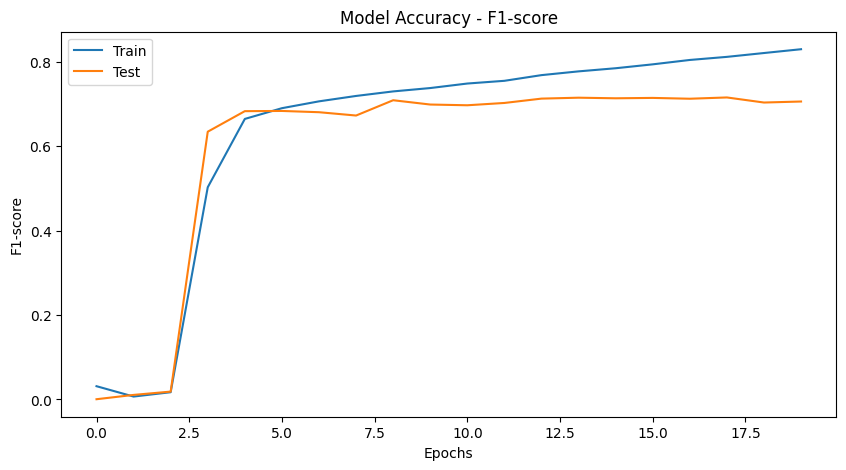

In [26]:
# Printing F1 score metric for trainig and validation
plt.figure(figsize=(10,5))
plt.plot(f1_score)
plt.plot(val_f1_score)
plt.title('Model Accuracy - F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend(['Train', 'Test'])
plt.show()

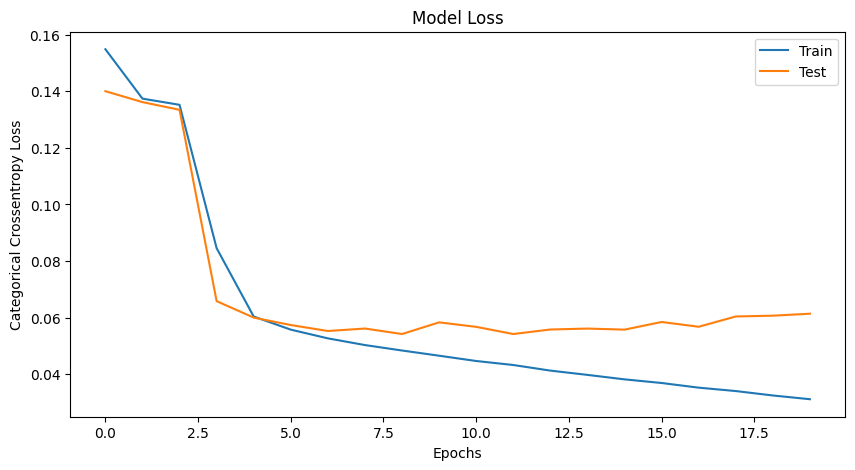

In [27]:
# Plotting loss curves
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.legend(['Train', 'Test'])
plt.show()

And the last step, evaluating and print the test data using our model.

In [28]:
# Printing model evaluation based on the test data
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test precision:', precision)
print('Test recall:', recall)
print('Test F1-score:', f1_score)

2000/2000 [==============================] - 25s 13ms/step - loss: 0.0948 - accuracy: 0.9894 - precision: 0.5290 - recall: 0.7244
Test loss: 0.09476814419031143
Test accuracy: 0.989355742931366
Test precision: 0.5289880633354187
Test recall: 0.7243757843971252
Test F1-score: 0.6114523631881209
